# **AM 207**: Homework 2

Verena Kaynig-Fittkau and Pavlos Protopapas  <br>
**Due: 11.59 P.M. Thursday March 3rd, 2015**

### Instructions:

+ Upload your answers in an ipython notebook to Canvas.

+ We will provide you imports for your ipython notebook. Please do not import additional libraries.

+ Your individual submissions should use the following filenames: AM207_YOURNAME_HW2.ipynb

+ Your code should be in code cells as part of your ipython notebook. Do not use a different language (or format). 

+ **Do not just send your code. The homework solutions should be in a report style. Be sure to add comments to your code as well as markdown cells where you describe your approach and discuss your results. **

+ Please submit your notebook in an executed status, so that we can see all the results you computed. However, we will still run your code and all cells should reproduce the output when executed. 

+ If you have multiple files (e.g. you've added code files or images) create a tarball for all files in a single file and name it: AM207_YOURNAME_HW2.tar.gz or AM207_YOURNAME_HW2.zip


### Have Fun!
_ _ _ _ _

In [188]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

from scipy import stats
import pandas as pd
import pymc as pm

import re
import math

# Problem 1: Geweke Convergence Test

In the lecture we have seen the Geweke test as one option to test for convergence of our metropolis hastings chain. Describe in your own words how the Geweke test works and its limitations. 

We provide you with the following code for the Geweke test. Write comments for the marked lines and any lines you think would be good to explain in addition. 

Write a short explanation of what the `rhot` function does and why it is necessary. 

Geweke diagnostic mimics the simple two‐sample test of means. If the
mean of the first 10% (or some length) of the chain is not significantly different from the last 50%, then we conclude the target distribution
converged somewhere in the first 10% of the chain. It can be used to determine the burn‐in period. (The smallest early portion of the
chain that passes the diagnostic.)

$$z=\frac{\bar{\theta}_a-\bar{\theta}_b}{\sqrt{ \rm{var}(\theta_a)+\rm{var}(\theta_b)}}$$

where $a$ and $b$ here are the early and late segments. If $z$ is small then this is an evidence of convergence. 

Geweke diagnostic was designed for a univariate case, so when expanding to multivariate situation, we must apply  additional diagnostics on between‐variable covariances (rhot function below).


In [203]:
# function takes in a subchain, x, and a length, t, it calculates the correlation
# coefficeint matrix between the first t steps of the chain and the last n-t steps of the chain.
# This informs us about the correlation between timepoints.

def rhot(x, t):
    n = len(x)
    return np.corrcoef(x[0:(n-t)], x[t:n])[0,1]

# function takes input (1) trace form sampling (2) number of intervals from the chain
# (3) size of each interval: Calculates the convergence score
def Geweke(trace, intervals, length):
    nsl=length
    # the size of the jump determines how far we want our subtraces to be apart
    jump = int(0.9*len(trace)/(2*intervals))
    # the first interval starts at the 10% of the chain
    first = 0.1*len(trace)
    
    z =np.empty(intervals)
    # for each interval 
    for k in np.arange(0, intervals):
        #begin point of the early subtrace is updated by moving k*jump ahead
        baga = np.int(first+k*jump)
        #begin point of the late subtrace is updated by moving k+jump ahead
        # the late subtraces are all taken from the second half of the trace
        bagb = len(trace)/2 + k*jump
        
        # segement the trace into 2 sub-traces to compare, each of length nsl
        sub_trace_a = trace[baga:baga+nsl]
        sub_trace_b = trace[bagb:bagb+nsl]
        
        # calculate the mean for each subtrace
        theta_a = np.mean(sub_trace_a)
        theta_b = np.mean(sub_trace_b)
        rho_a, rho_b = 1.0, 1.0
        # beginning after the first 10% of each subtrace
        for i in xrange(int(0.1*nsl)):
            # update the correlation coefficeints by calling rhot to compute the correlation
            # of the current 10% and the remainder of the chain
            rho_a += 2*rhot(sub_trace_a, i+1)
            rho_b += 2*rhot(sub_trace_b, i+1)
            
        # calculate the variance for each subchain including the correlation coefficient
        # to account for within subchain variance
        var_a  = np.var(sub_trace_a)*rho_a/length
        var_b  = np.var(sub_trace_b)*rho_b/length
        
        # calculate the z score as a comparison of the means by the adjusted
        #variances of each sample
        z[k] = (theta_a-theta_b)/np.sqrt( var_a + var_b)
    
    return z


# Problem 2: Message Response Times

The file `hangout_chat_data.csv` contains the response times of your friend Mark to google hangout chat messages in seconds. Use a method of your choice to read the file into a data frame or a numpy array. Your goal for this problem is to model Mark's chat response time distribution in a Bayesian framework. 

The description of the data sounds like a Poisson distribution is a good choice for our likelihood. We have messages arriving independently of each other, and instead of the arrival time we consider the time it took Mark to respond to the messages. 

* Load and describe the data by plotting a histogram of the response times. 
* Derive and compute the maximum likelihood solution for a Poisson distribution.
* Compare this to the Bayesian solution with a prior of your choice and using your own implementation of Metropolis Hastings to sample from the posterior. Make sure to describe why you chose this prior, as well as the specifics of your Metropolis Hastings implementation. 

* Analyze your sampling using traceplots and convergence tests. You can use the Geweke implementation given above. 
* Compare your solution to a solution using the MCMC class in pymc and write a brief discussion. Which parameters does your implementation need that the pymc implementation can do without? How do the traceplots compare? 

* Check your ML solution and the Bayesian solution against the data. If you know how you can use the posterior predictive for the Bayesian solution, otherwise you can use the MAP estimate or the expectation value of the posterior and compare that distribution to the data histogram. 

* Was our model a good choice for this problem? If yes great, if not, come up with a different Bayesian model that is better capable of capturing the data and show that it works better. 


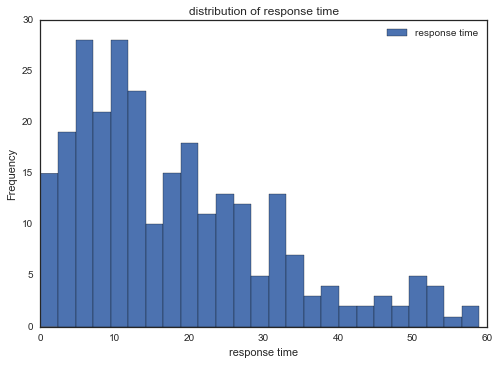

In [20]:
# import response time data
raw_data_df = pd.read_csv('hangout_chat_data.csv', header = None, names = ['response time'])

# plot a histogram
raw_data_df.plot.hist(bins = 25)
plt.xlabel('response time')
plt.title('distribution of response time')

** Raw Data: ** The data looks similar to a Poisson, but I would have doubts. One of my main concerns at this point is that Poisson distribution assuems a constant arrival time, but in this case response is a function of  recieving a message. Arrival time of messages is most likely not constant (ex. less overnight or offline). 

** Maximum Likelihood Estimate of $\lambda$:** Assuming $X \sim Poisson(\lambda)$, the likelihood of observing $X = x_1, x_2.., x_n$ independent samples from the Possion distribution:

$L = P(X|\lambda) = \prod\limits_{i=1}^n p(x_i|\lambda)= \prod\limits_{i=1}^n \frac{\lambda^{x_i}e^{-\lambda}}{x_i!}= \lambda^{\sum\limits_{i=1}^nx_i}e^{-n\lambda}$

Note that we dropped the denominator above because for our purposes it is not important since it is not a function of $\lambda$, so it will be the same for all $\lambda$ values. Maximising likelihood is equivalent to maximising the log likelihood but log likelihood makes computation easier:

$l = log(L) = log(\lambda^{\sum\limits_{i=1}^nx_i}) + log(e^{-n\lambda})= log\lambda\sum\limits_{i=1}^nx_i -n\lambda$

derivative of the log likelihood:

$\frac{dl}{d\lambda} =\big( \sum\limits_{i=1}^nx_i\big) /\lambda -n$

maximum likelihood estimate, $\lambda_{ML}$ is the value of $\lambda$ that solves $dl/d\lambda=0$

$\lambda_ML = \frac{\sum\limits_{i=1}^nx_i}{n}$

which is the mean of the observations, as we would expect for the Poisson distribution.

Plot the log likelihood for multiple values of $\lambda$ to get a sense of how it looks like. It may have multiple peaks (Poisson shouldn't but good practice in general I guess).

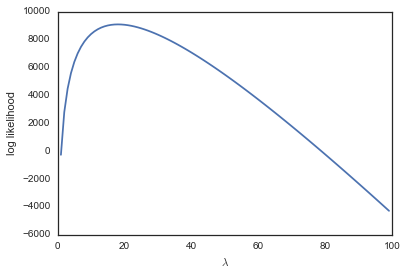

In [124]:
try_lams =  range(1,100)
sum_x = float(raw_data_df.sum(0))
n_x = raw_data_df.shape[0]
logl = map(lambda lam: sum_x*np.log(lam) - (n_x*lam), try_lams)
plt.plot(try_lams, logl)
plt.ylabel('log likelihood')
plt.xlabel('$\lambda$')

In [125]:
# ML esitmate for lambda is the mean
lambda_ML = float(raw_data_df.mean(0))
std_ML = float(raw_data_df.std(0))

print 'ML estimate of lambda', lambda_ML
print 'ML standard deviation',std_ML

ML estimate of lambda 18.0413533835
ML standard deviation 13.4308213706


**Bayesian Inference of $\lambda$ ** 

(1) decide on a proper prior - I chose to use an informative prior based on our previous observations and what we know about $\lambda$ based on the ML we did above, namely that it's expected value, mean, is 18 and its standard deviation (biased estimate of population standard deviation) is 13. So any prior distribution we end up choosing, should have this mean and std. 

(2) sample from the posterior by MH- 

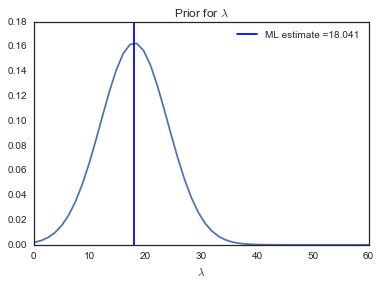

In [77]:
'''
prior 1 - Normal- 
sigma=13 gives lambda positive probability for lambda
values lower than zero which shouldn't be true, so we modify sigma until we reach 
full distribution is above zero.
'''
# plot the prior 
mu = 18
sig = 6

p_lam = lambda lam: (1/np.sqrt(2*np.pi*sig))*np.exp( - ((lam-mu)**2)/(2*sig**2))
asp = np.linspace(0.1,60)

prior=p_lam(asp)

plt.plot(asp, prior)
plt.xlabel('$\lambda$')
plt.title('Prior for $\lambda$')
plt.axvline(lambda_ML, label ='ML estimate =%.3f' %lambda_ML)
plt.legend(loc='best')
plt.show()


For MH, we choose a symmetric proposal distribution like uniform or Gaussian because it simplifies the acceptance probability:

$$A(x^{(i)},x^*) = min \Big(1 , \frac{p(x^*)q(x^{(i)}|x^*)}{p(x^{(i)})q(x^*|x^{(i)})} \Big) $$

since $q(x^*|x^{(i)}) = q(x^{(i)}|x^*)$.

Here, $p(x)$ is the posterior and is defined by:

$ P(\lambda|X) = P(X|\lambda) P(\lambda) $ 

We drop the proportionality factor again like we did in ML.

But here we notice that computing the posterior directly gives very small, almost all zero, values. To fix this I attempted calculating:

$$  P(\lambda|X) = exp(log( P(\lambda|X)) = exp(logP(X|\lambda)+log P(\lambda)) $$

However, this results in the same issue. 

The real fix was to note that MH algorithm for sampling from the posterior doesn't require keeping track of the actual posterior $P(\lambda|X)$ instead we only care about $\lambda$. Specifically we care for comparing a sample from uniform $ u \sim Uniform(0,1)$ to proportion of posteriors:
$$ u < \frac{ P(\lambda^*|X)}{ P(\lambda|X)}$$

Which is equivalent to:
$$ log(u) < log(\frac{ P(\lambda^*|X)}{ P(\lambda|X)})$$
$$ log(u) < logP(\lambda^*|X)-log P(\lambda|X)$$

In [200]:
# define functions:
log_likelihood = lambda lam: sum_x*np.log(lam) -n_x*lam
log_posterior = lambda lam: log_likelihood(lam) + np.log(p_lam(lam))
logA = lambda star,  prev: log_posterior(star) - log_posterior(prev) # log ratio of posteriors

# define two potential proposal distributions
rnorm = np.random.normal
runif = np.random.uniform 

def mh(sig, n,lam0):
    #initialize a list of samples of size n
    lams = np.zeros(n)
    #initial state
    lam_prev = rnorm(lam0,sig)
    # check that the lambda >0
    if lam_prev<=0:
        lam_prev = rnorm(lam0,sig)
        
    lams[0] = lam_prev
    for i in range(0,n-1):
        # propose a value by sampling from uniform 
        lam_star = rnorm(lam_prev,sig)
        # check that lambda > 0 if not sample again
        if lam_star<=0:
            lam_star = rnorm(lam0,sig)
        # randomly sample from uniform 
        U = runif()
        # acceptance condition (using logs)
        if np.log(U) < min(np.log(1), logA(lam_star,lam_prev) ):
            lams[i+1] = lam_star
            # the accepted sample becomes the current state
            lam_prev = lam_star
        else:
            lams[i+1] = lams[i]
    # return list of samples 
    return lams

**Convergence Diagnostics**

1- Trace plots

2- Geweke test

We observe from the results below that a smaller step size of 0.1 works best for convergence, however the initial guess did not matter.

Gweke diagnostic score : [ -6.26540844e+01  -4.82268005e+01  -1.04346309e+02  -1.52252163e+02
  -2.40973745e+01  -1.30005536e+02  -3.22665477e+01  -1.11799829e+02
  -5.93060633e+01  -4.07810660e+01  -3.08015863e+01  -2.28539941e+01
  -1.13051018e+00   1.17619420e+00   2.07553796e+00  -1.37445809e-01
  -2.42248951e+00   1.53455576e+00   8.13511508e-01  -1.67892595e-02]
mean of last half of trace 18.0053406414
std of last half of trace 0.0898529066905


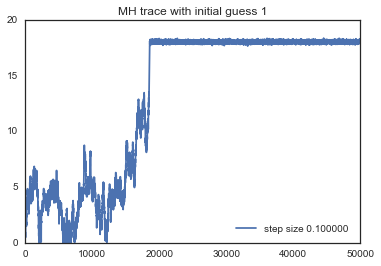

Gweke diagnostic score : [ 0.6381133   0.2091359   1.6009825  -0.20489198 -0.13093068  0.3139605
  1.00604199  2.60115346 -2.73202274 -0.36968786  1.19353332  1.01517534
  0.42398712  0.80301867  0.45475123 -1.54351043  0.57380249 -0.38200818
  1.01659896 -1.91690016]
mean of last half of trace 18.0309437968
std of last half of trace 0.251680802493


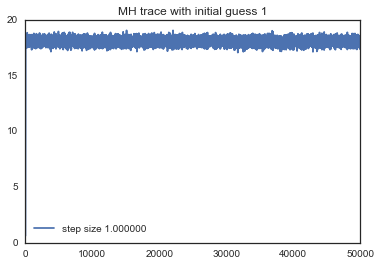

Gweke diagnostic score : [ 1.5254828  -0.14679069  0.75427489  0.57394551  0.28451837 -0.63240386
 -0.9110121  -1.3649625  -1.29048481 -1.3194489  -0.90532309 -1.79679023
 -0.49107816  0.81636668  0.74742975  1.39104346 -0.4289441   0.79404193
  0.04420107  1.14581909]
mean of last half of trace 16.9064022565
std of last half of trace 5.16244623046


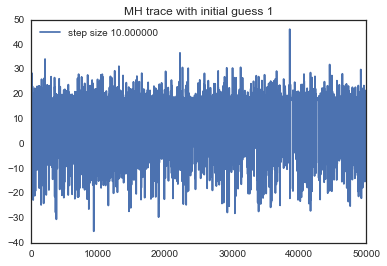

Gweke diagnostic score : [-37.75373114 -43.80941521  -8.57772935  -0.48803124   0.16787821
   2.43747362   0.32007593   1.54196031  -0.2844703    0.49648434
  -0.33017427  -0.52393581  -0.62895856   3.42056628   0.9472677
  -2.77073806   2.12084231  -0.39683796  -0.72279619  -0.15200904]
mean of last half of trace 18.004914653
std of last half of trace 0.0914774199617


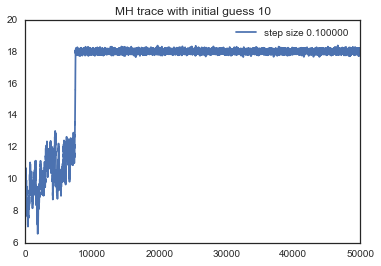

Gweke diagnostic score : [-2.16740723 -0.56983167 -0.0054084  -1.80580527 -1.01478703 -2.42405225
 -0.33293466 -1.97680953  0.08077859 -0.30995289  0.18162324 -0.18966241
  1.133336    4.42610644  2.1977837  -1.10119072  1.33205876  0.5676835
 -0.20910549 -0.08184148]
mean of last half of trace 18.0433786626
std of last half of trace 0.251050715069


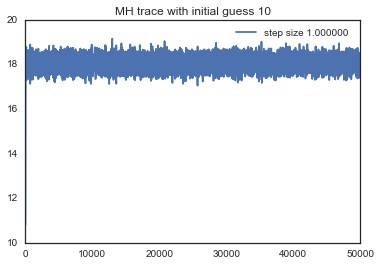

Gweke diagnostic score : [-1.0292961   0.2824084   0.33096077  1.26846897 -0.14286252 -0.45178138
 -0.45404071 -1.37330216 -0.24867868 -0.8902887   1.11852597 -0.82621825
 -0.89069609 -0.15210832 -4.77212831  1.01025994 -1.57622323 -0.09959917
  3.31557056 -0.45173017]
mean of last half of trace 17.8230499566
std of last half of trace 2.448651497


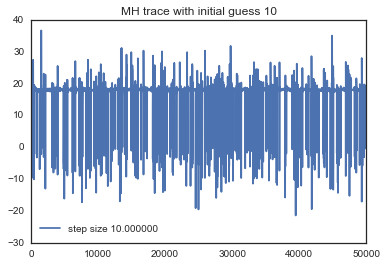

Gweke diagnostic score : [ 3.14173561  2.25351757  0.34709041  2.46651509  0.56670766 -0.4431067
  1.04406137  0.95546662  1.03648817 -5.02898164  1.20433327  0.0170551
 -1.71052879 -0.13289099  0.19779775 -0.22048243  0.56252356  0.46066952
  1.5535281  -1.1782308 ]
mean of last half of trace 18.0066575776
std of last half of trace 0.0946337863353


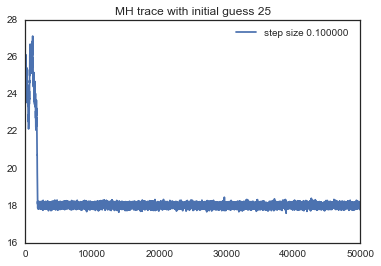

Gweke diagnostic score : [ 0.84328157 -0.96351034  2.01085369 -0.50996677 -0.49799054  0.46412947
 -1.4135965   0.61444819 -0.46391853  0.38791384  2.71438959 -0.54293883
  1.32003156 -1.20365387 -0.00419239 -1.13795412  0.7385985  -0.61163219
  0.85928271  1.01980139]
mean of last half of trace 18.0411320825
std of last half of trace 0.246883113845


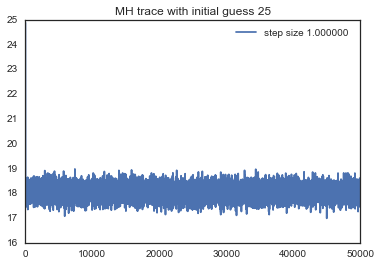

Gweke diagnostic score : [ 3.0490361   1.42196787  7.48415749 -1.66079937 -3.13198492  0.66247974
  1.05649862  2.68819193 -0.34023748 -4.15205492  0.33566982  1.10150506
 -0.18250426  1.69207203  3.45326204  1.31158033 -0.04669928 -1.61207824
  0.26384139 -0.0281364 ]
mean of last half of trace 18.0168014989
std of last half of trace 0.395952057607


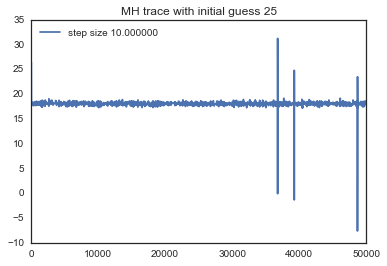

In [209]:
# plot the trace for different step sizes and starting lambdas
lam0s = [1,10,25]
sigs =[0.1,1,10]

# number of samples
n = 50000

for lam0 in lam0s:
    for sig in sigs:
        samples = mh(sig,n,lam0)
        print 'Gweke diagnostic score :', Geweke(samples, 20, 200)
        print 'mean of last half of trace',np.mean(samples[n/2:])
        print 'std of last half of trace',np.std(samples[n/2:])
        plt.plot(samples,label='step size %f '%sig)
        plt.title('MH trace with initial guess %d' %lam0)
        plt.legend(loc='best')
        plt.show()


**MCMC using PyMC module **

* Compare your solution to a solution using the MCMC class in pymc and write a brief discussion. Which parameters does your implementation need that the pymc implementation can do without? How do the traceplots compare? 

Couldn't get it to run

In [ ]:
# the pymc model

# priors 
lam = pymc.TruncatedNormal('lambda', value = init, mu= 18, tau = 6.0, a= 0)

# likelihood

In [ ]:
import model
S = pymc.MCMC(model, db='pickle')
S.sample(iter=10000, burn=5000, thin=2)
pymc.Matplot.plot(S)

model.py
import pymc
import numpy as np

# Priors on unknown parameters
init = 0.5; minv = 0.; maxv = 1.
theta = pymc.TruncatedNormal('theta', value=init, mu=0, tau=1., a=minv, b=maxv)

# Binomial likelihood for data
d = pymc.Binomial('d', n=100, p=theta, value=75,observed=True)


* Check your ML solution and the Bayesian solution against the data. 

Bayesian estimate 18.0331048458
Error 0.257604698098
ML estimate 18.0413533835


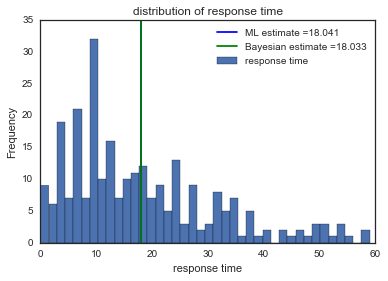

In [213]:
# use the parameters that resulted in the posterior with the smallest error
samples = mh(0.1,n,1)
print 'Bayesian estimate',np.mean(samples[n/2:])
print 'Error',np.std(samples[n/2:])
print 'ML estimate',lambda_ML
E_lambda_Bayes = np.mean(samples[n/2:])
# plot a histogram
raw_data_df.plot.hist(bins = 40)
plt.axvline(lambda_ML, label ='ML estimate =%.3f' %lambda_ML)
plt.axvline(E_lambda_Bayes,color = 'g' , label ='Bayesian estimate =%.3f' %E_lambda_Bayes)
plt.legend(loc='best')
plt.xlabel('response time')
plt.title('distribution of response time')

Based on the analysis above, i feel the model is fit for the data.  

# Problem 3: Markov Chains

* Given the following transition matrix, examine if the corresponding Markov Chain is irreducible and aperiodic. Note: No formal proof necessary, but you should give a solid argumentation.

$$ P = \left( 
\begin{array}{ccccc}
0.0 & 0.4 & 0.6 & 0.0 & 0.0 \\
0.65 & 0.0 & 0.35 & 0.0 & 0.0 \\
0.32 & 0.68 & 0.0 & 0.0 & 0.0 \\
0.0 & 0.0 & 0.0 & 0.12 & 0.88 \\
0.0 & 0.0 & 0.0 & 0.56 & 0.44 
\end{array}
\right ) $$



**Answer:** The chain is **not irreducable**. In an irreducable chain, regardless of the start state any state can be reached in finite time. This chain is reducable because it has a disconnect resulting in two subchains (1,2,3) and (4,5). Starting from either subchain prevents the chain from ever reaching the states in the other subchain. The subchains, however, are both irreducable. 
The chain is **aperiodic**. Both subchains have a period of 1. In an aperiodic chain, regardless of the start state, the chain can arrive at any given state in a random number of steps, as opposed to a periodic number of steps as is the case for periodic chains. 

# Problem 4: The Evidence 

In lectures we mostly concentrate on the likelihood and the prior and regard the evidence as a mere normalization factor. However, the evidence can be quite useful. In this problem you will compare different models by computing the evidence for each model, aka the probability that randomly selected parameters from a given model class would generate the data $X$.

As our models we compare polynomials of degree 0 to 4. For example for degree 2 we have $y = a_0 + a_1 \cdot x + a_2 \cdot x^2 + \epsilon$ where $\epsilon \sim N(0, \sigma) $ and $\theta = [a_0, a_1, a_2, \sigma]$. Assume that for all polynomials $a_i \sim \text{Expo}(1)$ and $\sigma \sim \text{Inverse Gamma}(1,1)$.


Bayes' theorem states that:
$$
P(\theta|x)=\frac{P(x|\theta)P(\theta)}{P(x)}
$$
$P(\theta)$ is the prior, $P(x|\theta)$ is the likelihood, $P(x)$ is called the evidence, and $P(\theta|x)$ is the posterior.

Your tasks are:

* Write down the mathematical equation of the evidence in terms of the likelihood and the prior. You don't need to solve the integral analytically, just write down its formula.
* Now you have the evidence in the form of an integral. Solve it by using importance sampling. What is a good choice for your importance sampling distribution?
* Compare the evidence for polynomials of degree 0 to 4. Which polynomial wins?

In [222]:
# Here is your data for the problem:
data = np.array([[ -1.85519254,  -2.7009541 ],
       [  4.38291824,  19.61735369],
       [  2.29495208,   3.96481822],
       [  0.02075668,   8.00646088],
       [  0.54097177,   2.8872262 ]])

x=data[:,0]
y=data[:,1]

**Answer ** The evidence is given by:

$P(D|M) = \int_{\theta} P(D|\theta)P(\theta|M)d\theta$ 

where $\theta = [a_0, a_1, a_2,a_3, a_4, \sigma]$

The priors for all parameters are given above. $P(a_j) = exp(-a_j)$ and $P(\sigma) = \sigma^{-2}exp(-1/\sigma)$
The likelihood is a joint probability over all 5 observations. Where the probability of observing each point $(x,y)$ is a normal:

$ P(x,y|\theta) = \frac{1}{\sigma\sqrt{2\pi}} exp(-( y-a_0 + a_1x + a_2x^2 + a_3x^3+ a_4x^4 )^2/2\sigma^2)$

So the likelihood for all observed data $D$:

$P(D|\theta) = \prod_i \frac{1}{\sigma\sqrt{2\pi}} exp(-( y_i-a_0 + a_1x_i + a_2x_i^2 + a_3x_i^3+ a_4x_i^4 )^2/2\sigma^2)$

$= \big(\frac{1}{\sigma\sqrt{2\pi}}\big)^n exp(-\frac{1}{2\sigma^2}\sum\limits_{i=1}^n( y_i-(a_0 + a_1x_i + a_2x_i^2 + a_3x_i^3+ a_4x_i^4) )^2$

and the evidence is:

$P(D|\theta) = \int_{a_0}\int_{a_1} \int_{a_2} \int_{a_3} \int_{a_4} \int_{\sigma} $
$\big(\frac{1}{\sigma\sqrt{2\pi}}\big)^n exp(-\frac{1}{2\sigma^2}\sum\limits_{i=1}^n( y_i-(a_0 + a_1x_i + a_2x_i^2 + a_3x_i^3+ a_4x_i^4) )^2$
$\big(exp(-a_0 - a_1 - a_2 - a_3 - a_4)\big) $
$\big( \sigma^{-2}exp(-1/\sigma)\big)da_0da_1da_2da_3da_4d\sigma$

We use importance sampling to find a value for the evidence.

In [240]:
# line
f = lambda x,a0,a1,a2,a3,a4: a0 + a1*x + a2*x**2 + a3*x**3 + a4*x**4
# likelihood for observation i
likelihood_i = lambda x_i, y_i,a0,a1,a2,a3,a4,sig: 0.000001 + stats.norm.pdf(y_i, loc=f(x_i,a0,a1,a2,a3,a4), scale=sig)
# joint likelihood for all observations
likelihood = lambda x, y,a0,a1,a2,a3,a4,sig: np.prod([likelihood_i(x_i, y_i,a0,a1,a2,a3,a4,sig) for x_i, y_i in zip(x,y)])
# priors for parameters
expo = lambda lam: np.random.exponential(lam,1)
invgamma = lambda a: stats.invgamma.rvs(a,1) 
# function to estimate
function_to_integrate = lambda x,y,a0,a1,a2,a3,a4,sig:\
likelihood(x, y,a0,a1,a2,a3,a4,sig)*\
np.exp(-a0-a1-a2-a3-a4)*sig**(-2)*np.exp(-1/sig)

def get_evidence(degree,x,y):
    # set default all parameters to zero
    params = np.zeros(5)
    # degree of polinomial
    for d in range(degree+1):
        params[d] = expo(1)
    sig = invgamma(1)
    a0,a1,a2,a3,a4 = params
    return function_to_integrate(x,y,a0,a1,a2,a3,a4,sig)  

print get_evidence(0,x,y)


9.92599382694e-17


'\nfor x_i,y_i in zip(x,y):\n    print f(x_i,a0,a1,a2,a3,a4)\n    print y_i\n    print likelihood_i(x_i, y_i,a0,a1,a2,a3,a4,sig)'

In [ ]:

# importance sampling
number_of_tries = 1000




_pdf = lambda x,y: control_variate_function(x,y)

estimates = np.zeros(number_of_tries)

# different runs for error estimate
for i in xrange(number_of_tries):
    # draw samples from our mixture of Gaussians. 
    # we draw half of the samples form one Gaussian and half from the other
    samples = gaussian1.rvs(size=number_of_samples*7/10)
    samples = np.vstack((samples, gaussian2.rvs(size=number_of_samples*3/10)))
    sample_x = samples[:,0]
    sample_y = samples[:,1]

    function_values = function_to_integrate(sample_a0,sample_a1,sample_a2,sample_a3,sample_a4,sample_sig)
    importance_weights = mixture_pdf(sample_x, sample_y)
 
    estimates[i] = np.mean(function_values / importance_weights)
    
importance_sampling_estimate = np.mean(estimates)
importance_sampling_error = np.std(estimates)

print "Estimated integral value: ", importance_sampling_estimate
print "Estimated error: ", importance_sampling_error

# Problem 5: Which YouTube Videos to Watch

Youtube videos have a like and an unlike flag. We can use these up and down votes on the videos to determine if a video is worth watching. However, it is not immediately obvious how to rank a video with just 3 up and 0 down rankings against a video with 300 up and 100 down votes. We will address this problem using a Bayesian approach.

Build two Bayesian models for the average upvote rate of a video. Both models should use the same likelihood, but different priors. Use one prior where people in general are rather undecided about videos, and one where people tend to be very opinionated. Compare the resulting posteriors for each video. How does the different choice of prior change your results? 

Given that there are so many videos on YouTube we want a really conservative way to decide if it is worth watching. Compute the 5th percentile for the posterior of each video and rank the videos according to this value. Is the 5th percentile a good indicator for the ranking? What are the benefits, what are potential drawbacks?

In [144]:
# Here is the [upvote, downvote] data for 4 different videos:
video_votes = np.array([[3,0],[300,100],[2,2],[200,100]])

** answer ** Let $\theta$ be the average rate of upvoting. Then with a fixed $\theta$ the distribution of the number of upvotes, $y$, in $n$ views (assuming all views vote which is a streach but simplifies the problem significantly) can be represented by the binomial distribution:

$$P(y|\theta,n) = \binom{n}{y} \theta^y (1-\theta)^{n-y} $$

But here we wish to make $\theta$ random. To model the uncertainty in $\theta$ we assume a prior probability over it. The Beta distribution is a good choice for this problem for:

1- logical reason: $Beta(\alpha,\beta)$ basically assigns 'imaginary votes' at the start to each new item. So instead of starting with 0 up and 0 down votes, we can start with $\alpha$ upvotes and $\beta$ downvotes. For example, we might expect people to have a higher tendency of upvoting so we set $\alpha=10$, $\beta=5$. 
After getting $y$ real upvotes, and $n-y$ real downvotes the posterior distribution is $Beta(\alpha+y, \beta+n-y)$. Basically, the parameters of beta can be modified to nicely accomodate voting tendencies and polarizations. 

2- practical reason: beta is the conjugate prior of the binomail so the posterior is also a beta distribution and easy to sample from. 

So the posterior for $\theta$ based on Bayes law is:

$$P(\theta|y,n) = \frac{P(y,n|\theta)P(\theta)}{\int P(y,n|\theta)d\theta}$$

Here we cannot ignore the normalization factor since it ensures that the value we have for the posterior is indeed a probability:

$P(y|n,\alpha,\beta)=\int P(y,n|\theta)d\theta = \int_{\theta} P(y|n,\theta) P(\theta|\alpha,\beta)d\theta $

$ = \int_{0}^{1} \Big( \binom{n}{y} \theta^y (1-\theta)^{n-y} \Big) \Big( \frac{1}{B(\alpha, \beta)} \theta^{\alpha -1} (1 - \theta)^{\beta -1} \Big) d\theta $

$= \binom{n}{y} \frac{1}{B(\alpha , \beta)} \int_{0}^{1}  \theta^{y + \alpha -1} (1 - \theta)^{n- y + \beta -1} $

$= \binom{n}{y} \frac{B(y + \alpha, n-y +\beta)}{B(\alpha,\beta)}
$

So finally the posterior form reduces to 


$ P(\theta|y,n) = \frac {\binom{n}{y}\frac{\theta^{y + \alpha -1} (1 - \theta)^{n- y + \beta -1}}{B(\alpha,\beta)}}{ \binom{n}{y}\frac{B(y + \alpha, n-y +\beta)}{ B(\alpha,\beta)}} = \frac{\theta^{y + \alpha -1} (1 - \theta)^{n- y + \beta -1}}{B(y + \alpha, n-y +\beta)}$

Which is the distribution $Beta(y + \alpha, n-y +\beta)$.


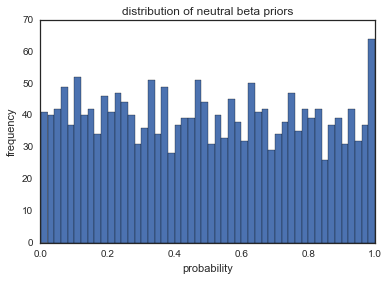

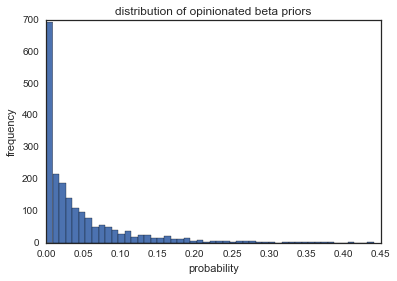

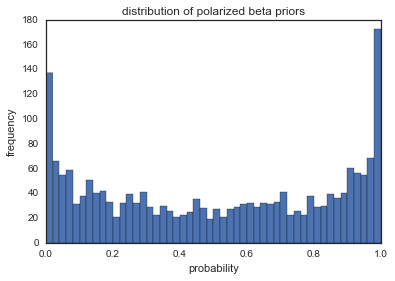

In [174]:
# plots of the beta distributions with different hyper parameters
neutral = np.random.beta(1,1,2000)
opinionated = np.random.beta(0.5,10,2000)
polarized = np.random.beta(0.5,0.5,2000)

plt.title('distribution of neutral beta priors')
plt.hist(neutral, bins = 50)
plt.xlabel('probability')
plt.ylabel('frequency')
plt.show()
plt.title('distribution of opinionated beta priors')
plt.hist(opinionated, bins = 50)
plt.xlabel('probability')
plt.ylabel('frequency')
plt.show()
plt.title('distribution of polarized beta priors')
plt.hist(polarized, bins = 50)
plt.xlabel('probability')
plt.ylabel('frequency')
plt.show()


The top two graphs show the distribution of $\theta$, the average upvoting rate.

$\theta$ in the first case has a normal distribution, so videos are equally likely to be voted up or down.  $\theta$ in the second case is biased towards videos getting voted down. $\theta$ in the third case shows polarization, where videos are either freqently voted up or frequently voted down. 

Sensitivity analysis: plotting the posterior to see how it changes with different priors as number of votes increases. We observe how the prior loses it's effect as number of votes increases.

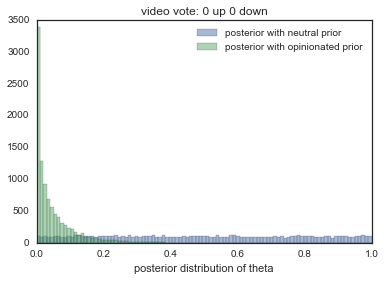

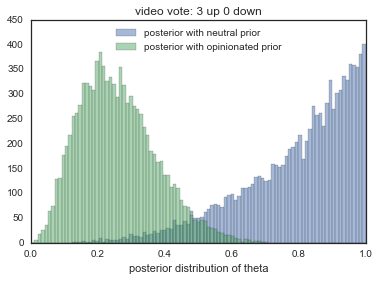

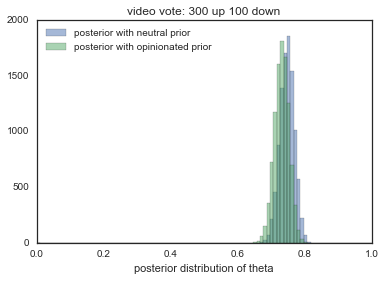

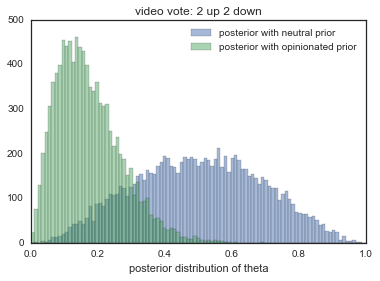

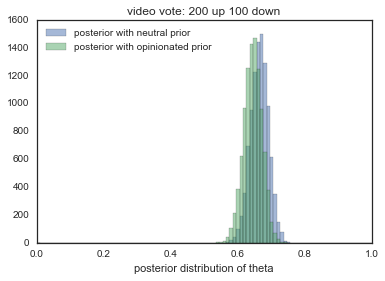

In [176]:
# define a function to plot the posteriors 
def upvote_posterior(y,n):    
    bins = np.linspace(0.0, 1.0, 100)
    neutral = np.random.beta(1+y,1+n-y,10000)
    opinionated = np.random.beta(0.5+y,10+n-y,10000)
    plt.hist(neutral, bins, alpha=0.5, label='posterior with neutral prior')
    plt.hist(opinionated, bins, alpha=0.5, label='posterior with opinionated prior')
    plt.legend(loc='best')
    plt.xlabel('posterior distribution of theta')
    plt.title('video vote: %d up %d down' %(y,n-y))
    plt.show()

# plot baseline case showing the general tendencies of the viewers
upvote_posterior(0,0)

# plot the posterior for different video votes
for video_vote in video_votes:
    y = video_vote[0] #upvotes
    n = video_vote[0] + video_vote[1]
    upvote_posterior(y,n)
    



In [184]:
# keep only the lowest 5% of the posterior distributions 

# define a function to sample randomly and keep the lowest 5% of the distribution 
def posterior_5percentile(y,n,percentile):
    neutral = np.random.beta(1+y,1+n-y,10000)
    opinionated = np.random.beta(0.5+y,10+n-y,10000)
    neutral_5 = np.percentile(neutral, percentile)
    opinionated_5 = np.percentile(opinionated, percentile)
    return (neutral_5, opinionated_5)

# return the 5th percentile of each video
for video_vote in video_votes:
    y = video_vote[0] #upvotes
    n = video_vote[0] + video_vote[1]
    print 'video_vote', video_vote 
    neutral_5, opinionated_5 = posterior_5percentile(y,n,5)
    print '5% with neutral prior', neutral_5
    print '5% with opinionated prior', opinionated_5


video_vote [3 0]
5% with neutral prior 0.476305002201
5% with opinionated prior 0.0933435430079
video_vote [300 100]
5% with neutral prior 0.711696004167
5% with opinionated prior 0.695171428472
video_vote [2 2]
5% with neutral prior 0.184980386637
5% with opinionated prior 0.0454462202414
video_vote [200 100]
5% with neutral prior 0.619741424727
5% with opinionated prior 0.600441605219


Using either prior, neutral or opinionated, ranks the videos based on the 5th percentile results from top to bottom: [300 100],[200 100], [3 0], [2 2]. 

This result makes sense, it gives precednece to -1- ratio of upvote to downvotes and -2- total number of votes, which are the factors that would logically indicate how good the videos are. 


In [185]:

# rank based on the median, or 50th percentile
for video_vote in video_votes:
    y = video_vote[0] #upvotes
    n = video_vote[0] + video_vote[1]
    print 'video_vote', video_vote 
    neutral_5, opinionated_5 = posterior_5percentile(y,n,50)
    print '5% with neutral prior', neutral_5
    print '5% with opinionated prior', opinionated_5

video_vote [3 0]
5% with neutral prior 0.840596400089
5% with opinionated prior 0.247825614619
video_vote [300 100]
5% with neutral prior 0.748944692444
5% with opinionated prior 0.732635679186
video_vote [2 2]
5% with neutral prior 0.498752338436
5% with opinionated prior 0.158398351928
video_vote [200 100]
5% with neutral prior 0.666107647385
5% with opinionated prior 0.645764692241


Actually it turns out that using the median, 50th percentile, is not as accurate. Instead ranking based on the median is sensitive to our choice of prior. 

with neutral prior the ranking is [3 0], [300 100],[200 100], [2 2]. 
with opinionated prior the ranking is [300 100],[200 100], [3 0], [2 2] (what we would expect)

Ranking posteriors using extreme percentiles as opposed to median seems more accurate when we are unsure about the prior. 